In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split


    

In [3]:
# Memory-map the feature array
X = np.load('/kaggle/input/natops-dataset/X.npy', mmap_mode='r')

# Memory-map the labels array
y = np.load('/kaggle/input/natops-dataset/y.npy', mmap_mode='r')

In [ ]:
X[0][0]

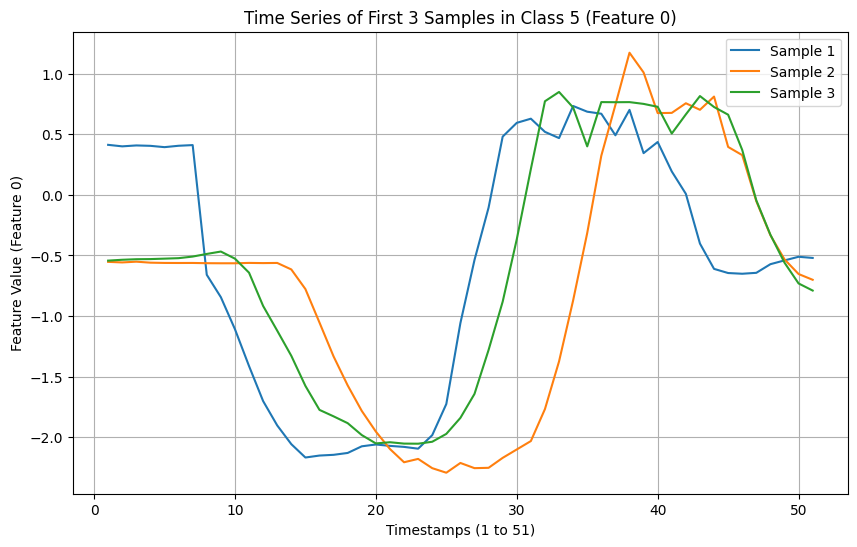

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y contains class labels and X contains features
class_label = '5.0'  # Class we want to visualize

# Extract first 10 samples from class 1
class_1_indices = np.where(y == class_label)[0][:3]
# Plot feature 0 over 51 timestamps
plt.figure(figsize=(10, 6))
for i, idx in enumerate(class_1_indices):
    plt.plot(range(1, 52), X[idx, 0, :], label=f'Sample {i+1}')  # Feature index 0

plt.xlabel("Timestamps (1 to 51)")
plt.ylabel("Feature Value (Feature 0)")
plt.title("Time Series of First 3 Samples in Class 5 (Feature 0)")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
target_values = []
indexes = []
for i in range(len(y)):
  if y[i] == '1.0':
    target_values.append(1)
    indexes.append(i)
  if y[i] == '2.0':
    target_values.append(2)
    indexes.append(i)
  if y[i] == '3.0':
     target_values.append(3)
     indexes.append(i)
  
  if y[i] == '4.0':
    target_values.append(4)
    indexes.append(i)
  if y[i] == '5.0':
    target_values.append(5)
    indexes.append(i)
  if y[i] == '6.0':
     target_values.append(6)
     indexes.append(i)
  else:
      pass

data = X[indexes]


# In[7]:


data = data[:,:20,:]



data.shape

(360, 20, 51)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data,
    target_values,
    test_size=0.3,      # 60% of the data will be in the test set
    stratify=target_values,  # Stratify by the class labels
    random_state=42     # For reproducibility
)



# Node initialization

class Node:
    def __init__(self,feature=None, threshold=None,interval = None,relation =None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.interval = interval
        self.relation = relation
        self.left = left
        self.right = right
        self.value = value

# ALLEN RELATIONS       

def allen_relation(interval1, interval2):
    x, y = interval1
    a, b = interval2

    if y == a:
        return "A"  # after
    elif y < a:
        return "L"  # later
    elif x == a and b < y:
        return "B"  # begins
    elif y == b and x < a:
        return "E"  # ends
    elif x < a and b < y:
        return "D"  # during
    elif x < a < y < b:
        return "O"  # overlaps
    elif x == a and y < b:
        return "B_complement"  # begins in
    elif x > a and y < b:
        return "D_complement"  # during in
    elif a < x and b == y:
        return "E_complement"  # ends in
    elif a < x and x == b :
        return "A_complent"  # during begins
    elif a < b < x < y:
        return "L_complement"  # ends begins
    elif a< x < y < b:
        return "O_complement"  # ends overlaps
    else:
        return "No relation"

# CHECKING THRESHOLD 

def check_values_greater_than_threshold(lst, threshold, percentage):
    count_greater = sum(1 for value in lst if value > threshold)
    return count_greater / len(lst) >= percentage

def generate_all_intervals(t):
    intervals = []
    for start in range(t-4):  # Ensure the interval has 5 timestamps

        intervals.append((start, start+5))

    return intervals

#INFORMATION GAIN

def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return - np.sum(probs*np.log(probs))

def information_gain(y, y_left, y_right):

    p = len(y_left) / len(y)
    entropy_parent = entropy(y)
    entropy_children = p * entropy(y_left) + (1 - p) * entropy(y_right)
    return entropy_parent - entropy_children

# GENERATING TIME INTERVALS FOR TIME SERIES

def generate_all_intervals(t):
    intervals = []
    for start in range(t-9):  # Ensure the interval has 8 timestamps

        intervals.append((start, start+10))

    return intervals

# FINDING THE BEST DECISIONS FOR SPLITTING

def findBestDecision_and_split(data, target_values,poss_intervals=generate_all_intervals(30)):
    best_feature = None
    best_threshold = None
    best_interval = None
    max_information_gain = -1
    best_rel = None

    Te = None
    Tu = None
    left_target = None
    right_target = None


    for feature in range(data.shape[1]):
      unique_values_array = []
      for i in range(data.shape[0]):
          sample = data[i,feature, :]  # Extract the i-th sample
          unique_values = np.unique(sample)  # Find the unique  values for the current sample
          unique_values_array.append(unique_values)
          thresholds = []
          for row in unique_values_array:
              thresholds.extend(list(row))

    for j in range(len(possible_intervals)):

            ref_interval = possible_intervals[j]


            for relation in relations:

              after_intervals = [(a, b) for a, b in possible_intervals if allen_relation(ref_interval, (a, b)) == relation]


              for threshold in thresholds:

                    left_data = []
                    left_y = []
                    right_data = []
                    right_y = []


                    for i in range(len(data)):


                        int_values = [data[i][feature][interval[0]:interval[1]+1] for interval in after_intervals]


                        if any(check_values_greater_than_threshold(lst,threshold, 0.75) for lst in int_values):
                            left_data.append(data[i])
                            left_y.append(target_values[i])

                        else:
                            right_data.append(data[i])
                            right_y.append(target_values[i])


                    inf_gain = information_gain(target_values,left_y, right_y)


                    if inf_gain > max_information_gain:

                            best_interval = ref_interval
                            max_information_gain = inf_gain
                            best_threshold = threshold
                            best_rel = relation
                            best_feature = feature
                            Te = left_data
                            Tu = right_data
                            left_target = left_y
                            right_target = right_y


                        # print(len(left_target),len(right_target))

    return best_feature,best_interval,best_threshold,best_rel,np.array(Te),np.array(Tu),left_target,right_target,max_information_gain


def CreateLeafNode(target_values):
    if len(target_values) == 0:
        # Return a default value when target_values is empty
        return Node(value = None)
    else:
        # Return the most common target value
        return Node(value=np.argmax(np.bincount(list(target_values))))

def CreateNode(data):
    return Node()

def Learn(data,target_values,poss_intervals=generate_all_intervals(30),max_depth=8, current_depth=0):

    if len(target_values) == 0 :
        return CreateLeafNode(target_values)
    if len(np.unique(target_values)) == 1 or max_depth <= current_depth or poss_intervals ==[] or relations ==[] :
        return CreateLeafNode(target_values)


    best_feature,best_interval,best_threshold,best_rel,Te,Tu,left_target,right_target,max_information_gain = findBestDecision_and_split(data, target_values,poss_intervals=generate_all_intervals(30))

    node = CreateNode(data)
    node.feature = best_feature
    node.threshold = best_threshold
    node.interval = best_interval
    node.relation = best_rel
    print("Left tree shape : ",Te.shape)
    print("Target values in the left tree : ",left_target)
    print('*******************************')
    print("Right tree shape : ",Tu.shape)
    print("Target values in the right tree : ",right_target)
    print("Feature number used : ",best_feature,"\nBest Interval : ",best_interval,", Best relation : ",best_rel,", Best Threshold : ",best_threshold)
    print('__________________________________________________________________________')
    print()

    node.left = Learn(Te,left_target,poss_intervals = generate_all_intervals(30) ,max_depth = 8,current_depth = current_depth + 1)
    node.right = Learn(Tu,right_target,poss_intervals = generate_all_intervals(30),max_depth = 8 ,current_depth = current_depth+1)

    return node

def TCART(data,target_values,poss_intervals,relations):

    tau = Node()

    tau = Learn(data,target_values,poss_intervals,max_depth=8, current_depth=0)
    return tau
relations = ["A","L","B","E","D","O","B_complement","D_complement","E_complement","A_complent","L_complement","O_complement"]
possible_intervals = generate_all_intervals(40)


# In[ ]:


tree  = TCART(X_train,y_train,poss_intervals = generate_all_intervals(40) ,relations=["A","L","B","E","D","O","B_complement","D_complement","E_complement","A_complent","L_complement","O_complement"])


# In[ ]:


Left tree shape :  (126, 20, 51)
Target values in the left tree :  [4, 6, 5, 6, 4, 5, 4, 4, 4, 5, 6, 5, 5, 4, 6, 5, 6, 4, 4, 4, 4, 5, 5, 6, 5, 6, 5, 5, 4, 4, 5, 5, 6, 6, 6, 4, 4, 5, 5, 4, 5, 5, 5, 4, 6, 4, 4, 4, 6, 4, 5, 6, 5, 4, 5, 5, 6, 6, 6, 6, 4, 4, 4, 5, 4, 4, 6, 6, 5, 5, 5, 4, 6, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 6, 6, 4, 5, 6, 6, 4, 4, 4, 5, 4, 4, 4, 6, 5, 5, 4, 6, 6, 4, 4, 4, 5, 4, 5, 6, 5, 6, 6, 4, 4, 6, 4, 6, 5, 6, 5, 6, 5, 6, 6, 6]
*******************************
Right tree shape :  (126, 20, 51)
Target values in the right tree :  [3, 2, 2, 1, 2, 1, 3, 1, 1, 2, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 2, 3, 2, 2, 3, 3, 1, 3, 2, 2, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 2, 1, 3, 2, 1, 2, 2, 2, 1, 3, 2, 3, 3, 3, 1, 1, 3, 1, 2, 3, 1, 3, 3, 2, 2, 2, 3, 3, 3, 1, 3, 2, 3, 1, 2, 2, 3, 2, 2, 2, 3, 3, 3, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 3, 1, 3, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 1, 3, 3, 1, 3, 2]
Feature number used :  19 
Best Interval :  (0, 10) , Best relation :  L ,

In [11]:
def predict(node, sample):
    if node.value is not None:

        return node.value
    feature = node.feature
    threshold = node.threshold
    interval = node.interval
    relation = node.relation
    left = node.left
    right = node.right
   # value = node.value

    after_intervals = [(a, b) for a, b in possible_intervals if allen_relation(interval, (a, b)) == relation]
    int_values = [sample[feature][interval[0]:interval[1]+1] for interval in after_intervals]


    if any(check_values_greater_than_threshold(lst,threshold, 0.75) for lst in int_values):
        return predict(node.left, sample)
    else:
        return predict(node.right, sample)
 

predictions = []

# Iterate over each sample in the test data
for sample in X_test:
    # Predict the target variable for the sample using the decision tree 'tau'
    predicted_value = predict(tree,sample)
    predictions.append(predicted_value)

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Print the predictions
print("Predictions:", predictions)

Predictions: [5 1 6 2 2 6 2 4 1 2 6 6 3 6 6 5 2 3 4 5 5 3 3 3 2 4 4 1 5 6 4 4 5 4 4 3 6
 5 2 5 1 2 3 4 5 3 4 1 2 2 3 5 4 4 5 6 3 2 2 2 2 3 3 2 3 4 4 1 2 5 4 1 3 2
 2 1 6 4 6 5 2 5 3 3 2 5 4 2 6 1 5 5 1 3 6 6 2 2 6 4 1 5 2 6 5 3 4 3]


In [1]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


# In[ ]:


from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test,predictions)

print("Confusion Matrix:")
print(conf_matrix)
# In[ ]:


from sklearn.metrics import precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

precision = precision_score(y_test, predictions, average= None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

print("Precision :",precision)
print("Recall :", recall)
print("F1 Score :", f1)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


# In[ ]:


from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test,predictions)

print("Confusion Matrix:")
print(conf_matrix)
# In[ ]:


from sklearn.metrics import precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

precision = precision_score(y_test, predictions, average= None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

print("Precision :",precision)
print("Recall :", recall)
print("F1 Score :", f1)

Accuracy: 0.81
Confusion Matrix:
[[12  2  1  0  0  0]
 [ 1 13  2  0  0  0]
 [ 0  1 14  1  0  0]
 [ 0  0  1 14  2  0]
 [ 0  0  0  1 16  1]
 [ 0  0  0  0  2 17]]
Precision : [0.86, 0.81, 0.82, 0.83, 0.84, 0.89]
Recall : [0.8, 0.87, 0.88, 0.82, 0.84, 0.85]
F1 Score : [0.83, 0.84, 0.85, 0.82, 0.84, 0.87]


In [4]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
precision = precision_score(y_test, predictions, average= 'weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print("Precision :",precision)
print("Recall :", recall)
print("F1 Score :", f1)

Accuracy: 0.851
Precision : 0.857
Recall : 0.851
F1 Score : 0.852
